# Taining Notebook

`SCGE133 - 6502062, 6502097, 6502107, 6502114`

---

In this notebook
- things

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 5.5 MB 30.1 MB/s 
     |████████████████████████████████| 163 kB 56.7 MB/s 
     |████████████████████████████████| 7.6 MB 58.0 MB/s 


In [ ]:
import transformers
from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers.optimization import get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#load dataset
dataset = pd.read_csv('emed_careers_cleaned_dropped.csv')

In [ ]:
from sklearn.preprocessing import OneHotEncoder


In [ ]:
#mlb = MultiLabelBinarizer()
#cl_jty = []
#for i in range(len(dataset)):
#  cl_jty.append([dataset['category'][i], dataset['job_type'][i]])
#
#dataset['Labels'] = cl_jty    

In [ ]:
#labels = mlb.fit_transform(dataset['Labels'])
#dataset['Labels'] = labels.tolist()

In [ ]:
enc = OneHotEncoder()
dataset['Labels'] =enc.fit_transform(dataset.category.values.reshape(-1, 1)).toarray().tolist()

In [ ]:
dataset['Labels']

0        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
29614    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
29615    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
29616    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
29617    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
29618    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Labels, Length: 29619, dtype: object

In [ ]:
dataset_new = dataset.drop(columns=['Unnamed: 0', 'company_name','job_title','location', 'category', 'job_type'])
dataset_new

,job_description,Labels
0,as part of our ongoing growth we are currently...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,manager of biometrics – italyal solutions are ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,a fantastic opportunity has arisen for an expe...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,job detailsutilise extensive clinical data man...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,hyper recruitment solutions are currently look...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
29614,job summarysenior clinical research associate ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29615,i am currently representing a global biopharma...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29616,seeking a clinical project managersenior clin...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29617,senior scientist sports screeningjob purposew...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
enc.categories_

[array(['clinical research', 'data management and statistics',
        'manufacturing  operations',
        'medical affairs  pharmaceutical physician',
        'medical information and pharmacovigilance',
        'pharmaceutical healthcare and medical sales',
        'pharmaceutical marketing', 'pharmacy', 'qualityassurance',
        'regulatory affairs', 'science'], dtype=object)]

## Dealing with data imbalance

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.256389
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.176475
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    0.165097
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.128364
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]    0.066984
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    0.059084
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.046997
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]    0.038826
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.034133
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.026064
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]    0.001587
Name: Labels, dtype: float64


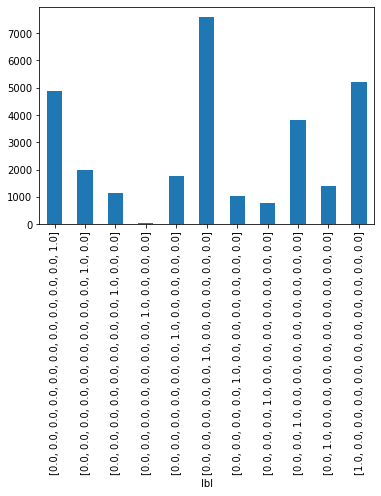

In [ ]:
print(dataset_new['Labels'].astype(str).value_counts(normalize=True))
labels_str = pd.DataFrame()
labels_str['lbl'] = dataset_new['Labels'].astype(str)
labels_str.groupby('lbl').size().plot(kind = 'bar', y = 'lbl', label = 'Type')

In [ ]:
# you're invited to ignore the graph above

In [ ]:
labels_str[(labels_str['lbl'].value_counts(normalize=True).reindex(labels_str['lbl'])>0.01).values].value_counts()

lbl                                                    
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    7594
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    5227
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    4890
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    3802
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]    1984
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    1750
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    1392
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]    1150
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    1011
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     772
dtype: int64

## Memorandum

For my sanity I will only upsample those data labels with more than 0.01 frequency

In [ ]:
dataset_new

,job_description,Labels
0,as part of our ongoing growth we are currently...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,manager of biometrics – italyal solutions are ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,a fantastic opportunity has arisen for an expe...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,job detailsutilise extensive clinical data man...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,hyper recruitment solutions are currently look...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
29614,job summarysenior clinical research associate ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29615,i am currently representing a global biopharma...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29616,seeking a clinical project managersenior clin...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29617,senior scientist sports screeningjob purposew...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
#dataset_new['lbl_str'] = dataset_new['Labels'].astype(str)
dataset_newer = dataset_new[(dataset_new['Labels'].astype(str).value_counts(normalize=True).reindex(dataset_new['Labels'].astype(str))>=0.1).values]
dataset_newer

,job_description,Labels
0,as part of our ongoing growth we are currently...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,manager of biometrics – italyal solutions are ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,a fantastic opportunity has arisen for an expe...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,hyper recruitment solutions are currently look...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,my client is currently recruiting for a senior...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
29612,quality specialistglobal medical device compa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29614,job summarysenior clinical research associate ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29616,seeking a clinical project managersenior clin...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29617,senior scientist sports screeningjob purposew...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
dataset_newer['Labels'].astype(str).value_counts(normalize=True)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.352996
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.242969
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    0.227304
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.176730
Name: Labels, dtype: float64

In [ ]:
#upsampling, finally
D_a = dataset_new[dataset_new['Labels'].astype(str) == '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]']
D_b = dataset_new[dataset_new['Labels'].astype(str) == '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]']
D_c = dataset_new[dataset_new['Labels'].astype(str) == '[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]']
D_d = dataset_new[dataset_new['Labels'].astype(str) == '[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]']
D_e = dataset_new[dataset_new['Labels'].astype(str) == '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]']
D_f = dataset_new[dataset_new['Labels'].astype(str) == '[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]']

D_all = [D_a, D_b, D_c, D_d, D_e, D_f]
D_all_upsampled = []

In [ ]:
from sklearn.utils import resample
for i in range(len(D_all)):
  upsample = resample(D_all[i],replace=True,n_samples=7500,random_state=0)

  print(upsample.shape)
  D_all_upsampled.append(upsample)

(7500, 2)
(7500, 2)
(7500, 2)
(7500, 2)
(7500, 2)
(7500, 2)


In [ ]:
dataset_newer = dataset_newer[(dataset_newer['Labels'].astype(str).value_counts(normalize=True).reindex(dataset_newer['Labels'].astype(str))>=0.1).values]
dataset_newer['Labels'].astype(str).value_counts(normalize=True)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.352996
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.242969
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    0.227304
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.176730
Name: Labels, dtype: float64

In [ ]:
for i in range(len(D_all_upsampled)):
  dataset_newer = pd.concat([dataset_newer, D_all_upsampled[i]])
dataset_newer

,job_description,Labels
0,as part of our ongoing growth we are currently...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,manager of biometrics – italyal solutions are ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,a fantastic opportunity has arisen for an expe...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,hyper recruitment solutions are currently look...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,my client is currently recruiting for a senior...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
3895,job summaryglobal biopharmaceutical – medical ...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8037,package £ per annumlocation south east londona...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3232,a rare opportunity with a global leading pharm...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28732,this role provides key medical input to an imp...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
dataset_newer['Labels'].astype(str).value_counts(normalize=True)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.114173
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]    0.112760
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    0.112760
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.112760
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.112760
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]    0.112760
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.112760
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.078586
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    0.073519
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.057162
Name: Labels, dtype: float64

## What's next?

Now that we finally have normalized data (somewhat), time to finally move on to model building

In [ ]:
del D_a, D_b, D_c, D_d, D_e, D_f, D_all, D_all_upsampled

## Downloading BERT model

In [ ]:
model_name = 'sentence-transformers/all-distilroberta-v1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
class tokenize_ds(Dataset):
   def __init__(self, text, labels, tokenizer, max_len):
      self.text = text
      self.labels = labels
      self.tokenizer = tokenizer
      self.max_len = max_len
   def __len__(self):
      return len(self.text)
   def __getitem__(self, item):
      text = str(self.text[item])
      label = self.labels[item]
      encoding = self.tokenizer.encode_plus(
         text,
         add_special_tokens=True,
         max_length=self.max_len,
         return_token_type_ids=False,
         padding='max_length',
         truncation=True,
         return_attention_mask=True,
         return_tensors='pt',
         )
      return {
         'text': text,
         'input_ids': encoding['input_ids'].flatten(),
         'attention_mask': encoding['attention_mask'].flatten(),
         'labels': torch.tensor(label, dtype=torch.long)
         }

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
# Creating a dataloader
def CreateDataLoader(df, tokenizer, max_len, batch_size):
   DS = tokenize_ds(
      text = df['job_description'].to_numpy(),
      labels = df['Labels'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
      )
   return DataLoader(DS, batch_size = batch_size, num_workers = 2)

In [ ]:
# split train, test, val
train, test = train_test_split(dataset_newer, train_size = 0.8, random_state=69420)
test, val = train_test_split(test, train_size = 0.5, random_state = 42069)

In [ ]:
# just a sanity check that data is not imbalanced in all these sets
print(train['Labels'].astype(str).value_counts(normalize=True))
print(test['Labels'].astype(str).value_counts(normalize=True))
print(val['Labels'].astype(str).value_counts(normalize=True))

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.113870
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]    0.113437
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.113306
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    0.113174
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.112986
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]    0.112610
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.112065
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.078143
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    0.072919
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.057489
Name: Labels, dtype: float64
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.117426
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.113817
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]    0.113817
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    0.109908
[0.0, 1.0, 0.0, 0.0

In [ ]:
# create a dataloader
batch_size = 16
max_len = 256
Traindata = CreateDataLoader(train, tokenizer, max_len, batch_size)
Valdata = CreateDataLoader(val, tokenizer, max_len, batch_size)
Testdata = CreateDataLoader(test, tokenizer, max_len, batch_size)

In [ ]:
# load the BERT model
bert_model = AutoModel.from_pretrained(model_name, return_dict=False)

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [ ]:
# model construction
class TextClassifier(nn.Module):
   def __init__(self, n_classes):
      super(TextClassifier, self).__init__()
      self.bert = AutoModel.from_pretrained(model_name,    
                  return_dict=False)
      self.drop = nn.Dropout(p=0.3)
      self.L1 = nn.Linear(self.bert.config.hidden_size, n_classes)
      self.L2 = nn.Linear(n_classes, n_classes)
      self.out = nn.Softmax(dim =1)
   def forward(self, input_ids, attention_mask):
      _, pooled_output = self.bert(
         input_ids = input_ids,
         attention_mask = attention_mask
         )
      output = self.drop(pooled_output)
      output = self.L1(output)
      output = self.drop(output)
      output = self.L2(output)
      output = self.out(output)
      return output

In [ ]:
model = TextClassifier(11)
model.bert.requires_grad_(False)
model = model.to(device)

In [ ]:
train.keys()

Index(['job_description', 'Labels'], dtype='object')

In [ ]:
encoding = tokenizer.encode_plus(
  str(train['job_description'][0]),
  max_length=256,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt', 
)

In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state = outputs[0]
pooled_output = outputs[1]

In [ ]:
last_hidden_state.shape

torch.Size([1, 256, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
data = next(iter(Traindata))
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [ ]:
input_ids.shape

torch.Size([16, 256])

In [ ]:
print(model(input_ids, attention_mask))

tensor([[0.0765, 0.0977, 0.1142, 0.0988, 0.0841, 0.0675, 0.0890, 0.0899, 0.1028,
         0.1142, 0.0654],
        [0.0745, 0.1132, 0.1068, 0.0912, 0.0958, 0.0664, 0.0786, 0.0902, 0.1040,
         0.1014, 0.0778],
        [0.0876, 0.1116, 0.0901, 0.0867, 0.0775, 0.0774, 0.0734, 0.0883, 0.1047,
         0.1328, 0.0698],
        [0.0776, 0.1131, 0.1006, 0.0932, 0.0830, 0.0798, 0.0672, 0.0877, 0.1078,
         0.1153, 0.0746],
        [0.0726, 0.1123, 0.1139, 0.0977, 0.0834, 0.0778, 0.0838, 0.0820, 0.1024,
         0.0953, 0.0788],
        [0.0793, 0.1395, 0.1031, 0.0933, 0.0804, 0.0761, 0.0805, 0.0737, 0.0988,
         0.1040, 0.0712],
        [0.0794, 0.1357, 0.0952, 0.0760, 0.1015, 0.0639, 0.0669, 0.0765, 0.1250,
         0.1042, 0.0757],
        [0.0889, 0.1125, 0.1109, 0.0962, 0.0957, 0.0760, 0.0748, 0.0804, 0.0924,
         0.0950, 0.0773],
        [0.0823, 0.1127, 0.1037, 0.1021, 0.0797, 0.0772, 0.0786, 0.0838, 0.0965,
         0.1090, 0.0745],
        [0.0753, 0.1253, 0.0966, 0.08

# Let's get to the model training, finally!

In [ ]:
# setup model training epoch
epochs = 5

optim = AdamW(model.parameters(), lr = 2e-3)
steps = len(Traindata) * epochs

scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=0,
    num_training_steps=steps
)

loss = nn.CrossEntropyLoss().to(device)

In [ ]:
# setup train epoch
def train_epoch(
    model,
    data_loader,
    loss,
    optim,
    device,
    scheduler,
    n_examples
  ):
  model = model.train()

  losses = []
  correct_predictions = 0.0
  p = 0
  for d in data_loader:
    if p % 100 == 0:
      print(f'p = {p} out of {len(data_loader)}')
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['labels'].type(torch.FloatTensor).to(device)
    optim.zero_grad()
    outputs = model(
      input_ids = input_ids,
      attention_mask = attention_mask
      )
    preds = torch.argmax(outputs, dim = 1)
    #print(torch.argmax(labels.float(), dim=1).long().cpu().numpy())
    #print(preds.cpu().numpy())
    loss_value = loss(outputs, labels)
    #print(np.count_nonzero((preds.cpu().numpy() == torch.argmax(labels.float(), dim=1).long().cpu().numpy())))
    correct_predictions += np.count_nonzero((preds.cpu().numpy() == torch.argmax(labels.float(), dim=1).long().cpu().numpy()))
    losses.append(loss_value.item())

    loss_value.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optim.step()
    scheduler.step()
    
    p+=1

  return correct_predictions/ n_examples, np.mean(losses)

In [ ]:
#setup evaluation stage
def eval_model(
    model,
    data_loader,
    loss,
    device,
    n_examples
):
  model = model.eval()
  losses = []
  correct_predictions = 0
  p = 0

  with torch.no_grad():
    for d in data_loader:
      if p % 100 == 0:
        print(f'p = {p} out of {len(data_loader)}')
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      labels = d['labels'].type(torch.FloatTensor).to(device)

      outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
        )
      preds = torch.argmax(outputs, dim = 1)
      #print(preds)
      loss_value = loss(outputs, labels)

      correct_predictions += np.count_nonzero((preds.cpu().numpy() == torch.argmax(labels.float(), dim=1).long().cpu().numpy()))
      losses.append(loss_value.item())
      p +=1
  return float(correct_predictions) / n_examples, np.mean(losses)

In [ ]:
%%time
# setup training step
def training_step(epochs):
  

  history = defaultdict(list)
  best_acc = 0
  for epoch in range(epochs):
    print(f'Epoch {epoch + 1} / {epochs}')

    train_acc, train_loss = train_epoch(
        model,
        Traindata,
        loss,
        optim,
        device,
        scheduler,
        len(train)
    )
    print(f'Training loss = {train_loss}, accuracy = {train_acc}')
    

    val_acc, val_loss = eval_model(
        model,
        Valdata,
        loss,
        device,
        len(val)
    )
    print(f'Validation loss = {val_loss}, accuracy = {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_acc:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_acc = val_acc

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


## And now, finally, at long last...

---
This block below, will be used to initiate the model's training step

In [ ]:
training_step(epochs)

Epoch 1 / 5
p = 0 out of 3326
p = 100 out of 3326
p = 200 out of 3326
p = 300 out of 3326
p = 400 out of 3326
p = 500 out of 3326
p = 600 out of 3326
p = 700 out of 3326
p = 800 out of 3326
p = 900 out of 3326
p = 1000 out of 3326
p = 1100 out of 3326
p = 1200 out of 3326
p = 1300 out of 3326
p = 1400 out of 3326
p = 1500 out of 3326
p = 1600 out of 3326
p = 1700 out of 3326
p = 1800 out of 3326
p = 1900 out of 3326
p = 2000 out of 3326
p = 2100 out of 3326
p = 2200 out of 3326
p = 2300 out of 3326
p = 2400 out of 3326
p = 2500 out of 3326
p = 2600 out of 3326
p = 2700 out of 3326
p = 2800 out of 3326
p = 2900 out of 3326
p = 3000 out of 3326
p = 3100 out of 3326
p = 3200 out of 3326
p = 3300 out of 3326
Training loss = 1.9572075453065492, accuracy = 0.6028002255215185
p = 0 out of 416
p = 100 out of 416
p = 200 out of 416
p = 300 out of 416
p = 400 out of 416
Validation loss = 1.853251235989424, accuracy = 0.6913710162357186
Epoch 2 / 5
p = 0 out of 3326
p = 100 out of 3326
p = 200 ou

# Model Evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model, '/content/drive/MyDrive/ML/model2.pt')

In [ ]:
final_acc, final_loss = eval_model(
        model,
        Testdata,
        loss,
        device,
        len(val)
    )

p = 0 out of 416
p = 100 out of 416
p = 200 out of 416
p = 300 out of 416
p = 400 out of 416


In [ ]:
final_acc

0.6873120865904991

In [ ]:
final_loss

1.855527464300394